# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import progressbar as pb
from ddpg_agent import Agent
from collections import deque
import time
from utils import save_results, show_agent_performance
from math import inf
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
The agent class execute **Deep Determinstic Policy Gradient** with a shared experience replay buffer for a certain number of agents.

In [6]:
# Creat an instance of the agent to be trained
ddpg = Agent(state_size=state_size,
             action_size=action_size,
             random_seed=1234,
             hidden_layers=[48, 24, 12],
             n_agents=num_agents
            )

The next function is meant to train the agents given the previous instance of the Agent class.

In [7]:
def train_agent(agent, n_episodes=10000, max_it=500, goal=.5, show_pb=True, stop=True, file_name='ddpg_model'):
    """ Train an agent using Deep Determinstic Policy Gradient learning
    
    Params
    ======
        agent (Agent): an agent that interacts with and learns from the environment
        n_episodes (int): maximum number of training episodes
        max_it (int): maximum number of iteration per episode
        goal (int): treshold to reach out for considering the environment solved
        show_pb (bool): flag to indicate if the progress bar is desried in the screen
        strop (bool): to indicate if the training shoul stop after the the environment is solved
        file_name (str): name of the location to save the results of the best model
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    best_performance = 0               # just to keep track of the performance during training
    widget = [pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    unfinished = True    #to mark itf the enivronment has been solved
 
    if show_pb:
        timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start() 
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        score = np.zeros(agent.n_agents)
        agent.reset()
        states = env_info.vector_observations                  # get the current states
        for t in range(max_it):
            actions = agent.act(states)                        # compute actions for each agent  
            env_info = env.step(actions)[brain_name]           # send the action to the environment
            next_states = env_info.vector_observations         # get next states
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        scores_window.append(np.max(score))       # save the average over all the agents in the last episode
        scores.append(np.max(score))              # save the average over all the agents in the last episode  
      
        if show_pb:
            timer.update(i_episode)    
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=best_performance:
            best_performance = np.mean(scores_window)
            save_results(agent,scores,file_name+"_best_weights.pth")
        if np.mean(scores_window)>=goal and unfinished:
            # The weights after solved the environment for the first time are saved
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            save_results(agent,scores,file_name+"_first_succesful_weights.pth")
            unfinished = False
            if stop:
                break
    if show_pb:
        timer.finish()
    return scores


### 4. Training a DDPG Agent during 10,000 episodes

Next, observe the performance of a trained DDPG agent that keeps learnig during 10,000 episodes even after it has solved the environment to visualize how stable it's the learning. Then it keeps the weights that yielded the highest 100 episode-average score.

In [8]:
begin = time.time()
scores_longer_run = train_agent(ddpg, goal=.5, show_pb=False, stop=False,file_name='ddpg_model')
print('Training time: {:.4} minutes'.format((time.time()-begin)/60))

Episode 100	Average Score: 0.0010
Episode 200	Average Score: 0.0000
Episode 300	Average Score: 0.0000
Episode 400	Average Score: 0.0000
Episode 500	Average Score: 0.0000
Episode 600	Average Score: 0.0000
Episode 700	Average Score: 0.0000
Episode 800	Average Score: 0.0010
Episode 900	Average Score: 0.0010
Episode 1000	Average Score: 0.0020
Episode 1100	Average Score: 0.0126
Episode 1200	Average Score: 0.0090
Episode 1300	Average Score: 0.0030
Episode 1400	Average Score: 0.0370
Episode 1500	Average Score: 0.0593
Episode 1600	Average Score: 0.0929
Episode 1700	Average Score: 0.1632
Episode 1800	Average Score: 0.1746
Episode 1900	Average Score: 0.2832
Episode 2000	Average Score: 0.3427
Episode 2100	Average Score: 0.3968

Environment solved in 2169 episodes!	Average Score: 0.5080
Episode 2200	Average Score: 0.6144
Episode 2300	Average Score: 0.3170
Episode 2400	Average Score: 0.5343
Episode 2500	Average Score: 0.2909
Episode 2600	Average Score: 0.3849
Episode 2700	Average Score: 0.3305
Epis

In [10]:
# We savethe las weights and obtained scores
save_results(ddpg,scores_longer_run,"ddpg_model_after_10000_episodes.pth")

### 5. Results
Right below we have the graph of the performance during the training session, the environment was at episode 2169 and got even better result in latter episodes and never crashing down to zero again

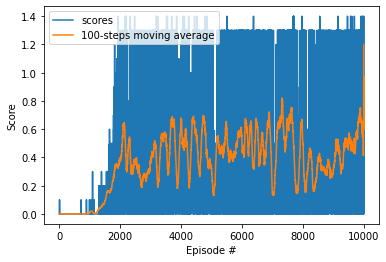

In [11]:
show_agent_performance(scores_longer_run)

#### 5.1 Zoom from episode 0 to the solution episode
We can at the earliest sages that the learning keeps making progress in a steady fashion to finally solved the task.

The environment was solved at episode: 2169


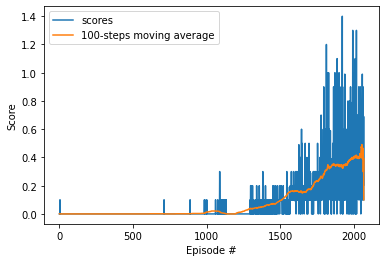

In [12]:
avg_scores = [np.mean(scores_longer_run[i:i+100]) for i in range(len(scores_longer_run)-99)]
resolution_episode = next(i for i, score in enumerate(avg_scores) if score >= 0.5)
print("The environment was solved at episode: {}".format(resolution_episode+100))
show_agent_performance(scores_longer_run[0:resolution_episode])

#### 5.1.1 Zoom for the first 100-episodes that solved the task [2070 ,2169]

Graph of the episodes that solved the best environment: 


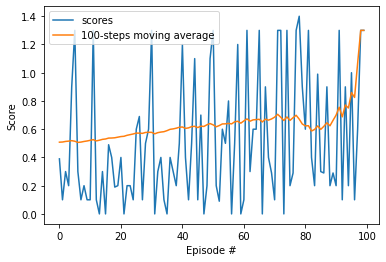

In [13]:
print("Graph of the episodes that solved the best environment: ")
show_agent_performance(scores_longer_run[resolution_episode:resolution_episode+100])

#### 5.2 Zoom for the 100-episodes that solved the that got the best performance [8382,8481]

The results during the training stage are:
The best episode  scored: 1.4000000208616257
The best 100 episode average scores: 0.7426000110991299
The best average score was reached at episode 8481
Graph of the episodes that got the best average score: 


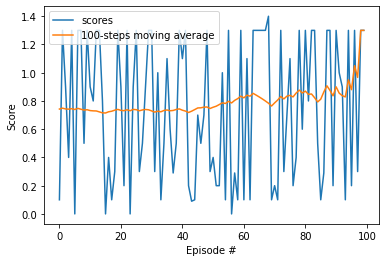

In [19]:
reached_goal_episode = np.argmax(avg_scores)
print("The results during the training stage are:")
print("The best episode  scored: {}".format(np.max(scores_longer_run)))
print("The best 100 episode average scores: {}".format(np.max(avg_scores)))
print("The best average score was reached at episode {}".format(reached_goal_episode+100))
print("Graph of the episodes that got the best average score: ")
show_agent_performance(scores_longer_run[reached_goal_episode:reached_goal_episode+100])

If you are done, you can close  the environment.

In [14]:
env.close()